<a href="https://colab.research.google.com/github/rajsahu2004/Rock-Physics-Project/blob/main/Model_tunning_and_Seismic_parameter_estimation_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [173]:
import numpy as np
import pandas as pd
try:
  import bruges.rockphysics as brp
except:
  %pip install bruges
  import bruges.rockphysics as brp
try:
  import lasio
except:
  %pip install lasio
  import lasio
import matplotlib.pyplot as plt

**1. Critial Porosity Model Nur et al. (1991, 1995).**

In [174]:
def Cpor_model(K0, G0, phi, phic=0.4):
    #K0,G0= Bulk Modulus and shear Modulus of Mineral Matrix
    #Phic = Crtical Porosity defalut value = 0.4 9for sandstone
    K_dry  = K0 * (1-phi/phic)
    G_dry  = G0 * (1-phi/phic)
    return K_dry, G_dry

In [175]:
Dqz, Kqz, Gqz = 2.65, 36.6, 45 #matrix properties of Sandstone
Dsh, Ksh, Gsh = 2.5, 11.5, 3.5    #matrix properties of Shale(Clay)



**2. Hertz-Mindlin Model for soft and Stiff Sand**

In [176]:
def HM_model(K0, G0, phic=0.4, Cn=8.6, sigma=10, f=1):
    '''
    K0, G0: mineral bulk & shear modulus in GPa
    phi: porosity
    phic: critical porosity (default 0.4)
    Cn: coordination nnumber (default 8.6)
    sigma: effective stress in MPa (default 10)
    f: shear modulus correction factor
       1=dry pack with perfect adhesion
       0=dry frictionless pack
    '''
    sigma /=1e3 # Pressure in GPa
    PR0=(3*K0-2*G0)/(6*K0+2*G0) # poisson's ratio of mineral mixture
    K_HM = (sigma*(Cn**2*(1-phic)**2*G0**2) / (18*np.pi**2*(1-PR0)**2))**(1/3)
    G_HM = ((2+3*f-PR0*(1+3*f))/(5*(2-PR0))) * ((sigma*(3*Cn**2*(1-phic)**2*G0**2)/(2*np.pi**2*(1-PR0)**2)))**(1/3)
    return K_HM, G_HM

We are getting Bulk and Shear Modulus values for dry rock at Critical Porosity ,

Using this values we will be evaluating dry rock elastic properties(effective) for any arbitary porosity

In [177]:
def SoftSandModel(K0, G0, phi, phic=0.4, Cn=8.6, sigma=10, f=1):
    '''
    K0, G0: mineral bulk & shear modulus in GPa
    phi: porosity
    phic: critical porosity (default 0.4)
    Cn: coordination nnumber (default 8.6)
    sigma: effective stress in MPa (default 10)
    f: shear modulus correction factor
       1=dry pack with perfect adhesion
       0=dry frictionless pack
    '''
    K_HM, G_HM = HM_model(K0, G0, phic, Cn, sigma, f)
    K_DRY =-4/3*G_HM + (((phi/phic)/(K_HM+4/3*G_HM)) + ((1-phi/phic)/(K0+4/3*G_HM)))**-1
    temp = G_HM/6*((9*K_HM+8*G_HM) / (K_HM+2*G_HM))
    G_DRY = -temp + ((phi/phic)/(G_HM+temp) + ((1-phi/phic)/(G0+temp)))**-1
    return K_DRY, G_DRY


**2b. Stiff Sand Model (heuristic modified Hashin–Shtrikman Upper bound)**

In [178]:
def StiffSandModel(K0, G0, phi, phic=0.4, Cn=8.6, sigma=10, f=1):
    '''
    K0, G0: mineral bulk & shear modulus in GPa
    phi: porosity
    phic: critical porosity (default 0.4)
    Cn: coordination nnumber (default 8.6)
    sigma: effective stress in MPa (default 10)
    f: shear modulus correction factor
       1=dry pack with perfect adhesion
       0=dry frictionless pack
    '''
    K_HM, G_HM = HM_model(K0, G0, phic, Cn, sigma, f)
    K_DRY = -4/3*G0 + (((phi/phic)/(K_HM+4/3*G0)) + ((1-phi/phic)/(K0+4/3*G0)))**-1
    temp = G0/6*((9*K0+8*G0) / (K0+2*G0))
    G_DRY = -temp + ((phi/phic)/(G_HM+temp) + ((1-phi/phic)/(G0+temp)))**-1
    return K_DRY, G_DRY

**3. Gassman Fluid Substitution**

In [179]:
def Gassman_FS(K_DRY,G_DRY,K0,Kf,D0,Df,phi):
    '''
    Calculates velocities and densities of saturated rock via Gassmann equation, (C) aadm 2015

    INPUT
    K_DRY,G_DRY: dry rock bulk & shear modulus in GPa
    K0, D0: mineral bulk modulus and density in GPa
    Kf, Df: fluid bulk modulus and density in GPa
    phi: porosity
    '''
    rho  = D0*(1-phi)+Df*phi
    K = K_DRY + (1-K_DRY/K0)**2 / ( (phi/Kf) + ((1-phi)/K0) - (K_DRY/K0**2) )

    return K,G_DRY,rho

In [180]:
def velocity(K,G,rho):
    '''
    Calculates velocities and densities of saturated rock

    INPUT
    K_DRY,G_DRY: dry rock bulk & shear modulus in GPa
    K0, D0: mineral bulk modulus and density in GPa
    Kf, Df: fluid bulk modulus and density in GPa
    phi: porosity
    '''
    vp   = np.sqrt((K+4./3*G)/rho)*1e3
    vs   = np.sqrt(G/rho)*1e3
    return vp, vs

In [181]:
def vrh(f,M1,M2):
    '''
    Simple Voigt-Reuss-Hill bounds for 2-components mixture, (C) aadm 2017

    INPUT
    f: volumetric fraction of mineral 1
    M1: elastic modulus mineral 1
    M2: elastic modulus mineral 2

    OUTPUT
    M_Voigt: upper bound or Voigt average
    M_Reuss: lower bound or Reuss average
    M_VRH: Voigt-Reuss-Hill average
    '''
    M_Voigt = f*M1 + (1-f)*M2
    M_Reuss = 1/ ( f/M1 + (1-f)/M2 )
    M_VRH   = (M_Voigt+M_Reuss)/2
    return M_Voigt, M_Reuss, M_VRH

# Rock-Physics Model Building

**Assuming the Parameters Considering an Real Reservoir Conditions**

In [182]:
Den_qz, Kqz, Gqz = 2.65, 36.6, 45 # Quartz density and elastic properties
Den_sh, Ksh, Gsh = 2.7, 21, 7    # Shale density and elastic properties
Kc, Gc = 36.6, 45  #Cement's elastic co-efficients in GPa. for Quartz
                    #and for shale it will be 21,7 and 76.8 and 32 for calcite

Db, Kb = 1, 2.2  # Density and Bulk Modulus of the Brine
Do, Ko = 0.8, 1.5 # Density and Bulk Modulus of the Oil
Dg, Kg = 0.2, 0.06 # Density and Bulk Modulus of the Gas

In [183]:
def contactcement(K0, G0, phi, phic=0.4, Cn=8.6, Kc=37, Gc=45, scheme=2):
    '''
    Contact cement (cemented sand) model, Dvorkin-Nur (1996)
    written by Alessandro Amato del Monte (2015)
    from Mavko et al., Rock Physics Handbook, p.255

    Args:
        K0, G0: mineral bulk & shear modulus in GPa
        phi: porosity
        phic: critical porosity (default 0.4)
        Cn: coordination nnumber (default 8.6)
        Kc, Gc: cement bulk & shear modulus in GPa (default 37, 45 i.e. quartz)
        scheme: 1=cement deposited at grain contacts, 2=in uniform layer around grains (default 2)
    Returns:
        Tuple: K_DRY, G_DRY: dry rock bulk & shear modulus in GPa
    '''
    PR0=(3*K0-2*G0)/(6*K0+2*G0)
    PRc = (3*Kc-2*Gc)/(6*Kc+2*Gc)
    if scheme == 1: # scheme 1: cement deposited at grain contacts
        alpha = ((phic-phi)/(3*Cn*(1-phic))) ** (1/4)
    else: # scheme 2: cement evenly deposited on grain surface
        alpha = ((2*(phic-phi))/(3*(1-phic)))**(1/2)
    LambdaN = (2*Gc*(1-PR0)*(1-PRc)) / (np.pi*G0*(1-2*PRc))
    N1 = -0.024153*LambdaN**-1.3646
    N2 = 0.20405*LambdaN**-0.89008
    N3 = 0.00024649*LambdaN**-1.9864
    Sn = N1*alpha**2 + N2*alpha + N3
    LambdaT = Gc/(np.pi*G0)
    T1 = -10**-2*(2.26*PR0**2+2.07*PR0+2.3)*LambdaT**(0.079*PR0**2+0.1754*PR0-1.342)
    T2 = (0.0573*PR0**2+0.0937*PR0+0.202)*LambdaT**(0.0274*PR0**2+0.0529*PR0-0.8765)
    T3 = 10**-4*(9.654*PR0**2+4.945*PR0+3.1)*LambdaT**(0.01867*PR0**2+0.4011*PR0-1.8186)
    St = T1*alpha**2 + T2*alpha + T3
    K_DRY = 1/6*Cn*(1-phic)*(Kc+(4/3)*Gc)*Sn
    G_DRY = 3/5*K_DRY+3/20*Cn*(1-phic)*Gc*St
    return K_DRY, G_DRY


# Rock-Physics Template Building

In [184]:
try:
  las = lasio.read('data/gorgonichthys_1_wire_gold.las',engine='normal')
except:
  print('Fetching from github...')
  las = lasio.read('https://raw.githubusercontent.com/rajsahu2004/Rock-Physics-Project/main/data/gorgonichthys_1_wire_gold.las',engine='normal')

Fetching from github...


In [185]:
data = las.df()
data.reset_index(inplace=True)
data.head()

,DEPTH,AI,BADHOLE,BMOD,CAL,COAL,DRHO_GOLD,DTC_GOLD,DTC_PRED,DTS_GOLD,...,SI,SMOD,SWT,SXOT,VOL_WETCLAY,VP,VPVS,VS,YMD,YMOD
0,196.90079,NaN,0.0,NaN,NaN,0.0,NaN,NaN,77.8546,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,197.05319,NaN,0.0,NaN,NaN,0.0,NaN,NaN,77.6582,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,197.20559,NaN,0.0,NaN,NaN,0.0,NaN,NaN,77.4047,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,197.35799,NaN,0.0,NaN,NaN,0.0,NaN,NaN,76.8988,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,197.51039,NaN,0.0,NaN,NaN,0.0,NaN,NaN,75.9863,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [186]:
columns_needed = ['DEPTH','DT','DTS','GR','RHO','VP','VS','VPVS','IP','IS','VCL','RHOm','RHOf','PHIE','SWT']
data.columns

Index(['DEPTH', 'AI', 'BADHOLE', 'BMOD', 'CAL', 'COAL', 'DRHO_GOLD',
       'DTC_GOLD', 'DTC_PRED', 'DTS_GOLD', 'DTS_PRED', 'GR_GOLD', 'K', 'KINT',
       'LAMRH', 'MURH', 'NETSAND', 'NPHI_GOLD', 'PAY', 'PEF', 'PHIE', 'PHIT',
       'PR', 'RES_DEEP_GOLD', 'RES_SHALLOW_GOLD', 'RHOB_GOLD', 'RHOB_PRED',
       'SI', 'SMOD', 'SWT', 'SXOT', 'VOL_WETCLAY', 'VP', 'VPVS', 'VS', 'YMD',
       'YMOD'],
      dtype='object')

In [187]:
L = data[['DEPTH','DTC_GOLD','DTS_GOLD','GR_GOLD','RHOB_GOLD','VP','VS','VPVS','AI','SI','VOL_WETCLAY','PHIE','SWT']]
L.loc[:,'RHOm'] = 2.65
L.loc[:,'RHOf'] = 1
L = L.dropna()
DEPTH_MIN = 3928.3
DEPTH_MAX = 4090.5
L = L[(L['DEPTH']>DEPTH_MIN) & (L['DEPTH']<DEPTH_MAX)]
L.head()

<ipython-input-187-22819802f14a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  L.loc[:,'RHOm'] = 2.65
<ipython-input-187-22819802f14a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  L.loc[:,'RHOf'] = 1


,DEPTH,DTC_GOLD,DTS_GOLD,GR_GOLD,RHOB_GOLD,VP,VS,VPVS,AI,SI,VOL_WETCLAY,PHIE,SWT,RHOm,RHOf
24485,3928.41373,75.0295,127.905,90.7562,2.6661,13328.0908,7818.3027,1.7047,35533.9219,20844.3184,0.575355,0.001001,1.0,2.65,1
24486,3928.56613,74.5634,128.394,95.7989,2.6673,13411.4053,7788.5259,1.7219,35771.8203,20774.0898,0.562940,0.001001,1.0,2.65,1
24487,3928.71853,74.2541,128.675,100.0100,2.6684,13467.2705,7771.5171,1.7329,35936.6641,20737.8613,0.582759,0.001001,1.0,2.65,1
24488,3928.87093,73.6112,128.530,106.8610,2.6696,13584.8896,7780.2847,1.7461,36266.4961,20770.4062,0.589147,0.001001,1.0,2.65,1
24489,3929.02333,72.8832,128.140,112.0420,2.6708,13720.5830,7803.9644,1.7582,36644.8828,20842.8008,0.586680,0.001001,1.0,2.65,1


In [188]:
# Names needed: ['DEPTH','DT','DTS','GR','RHO','VP','VS','VPVS','IP','IS','VCL','RHOm','RHOf','PHIE','SWT]
col_rename = {
    'DEPTH':'DEPTH',
    'DTC_GOLD':'DT',
    'DTS_GOLD':'DTS',
    'GR_GOLD':'GR',
    'RHOB_GOLD':'RHO',
    'VP':'VP',
    'VS':'VS',
    'VPVS':'VPVS',
    'AI':'IP',
    'SI':'IS',
    'VOL_WETCLAY':'VCL',
    'PHIE':'PHIE',
    'SWT':'SW'
}
L.rename(columns = col_rename,inplace = True)
L.columns

Index(['DEPTH', 'DT', 'DTS', 'GR', 'RHO', 'VP', 'VS', 'VPVS', 'IP', 'IS',
       'VCL', 'PHIE', 'SW', 'RHOm', 'RHOf'],
      dtype='object')

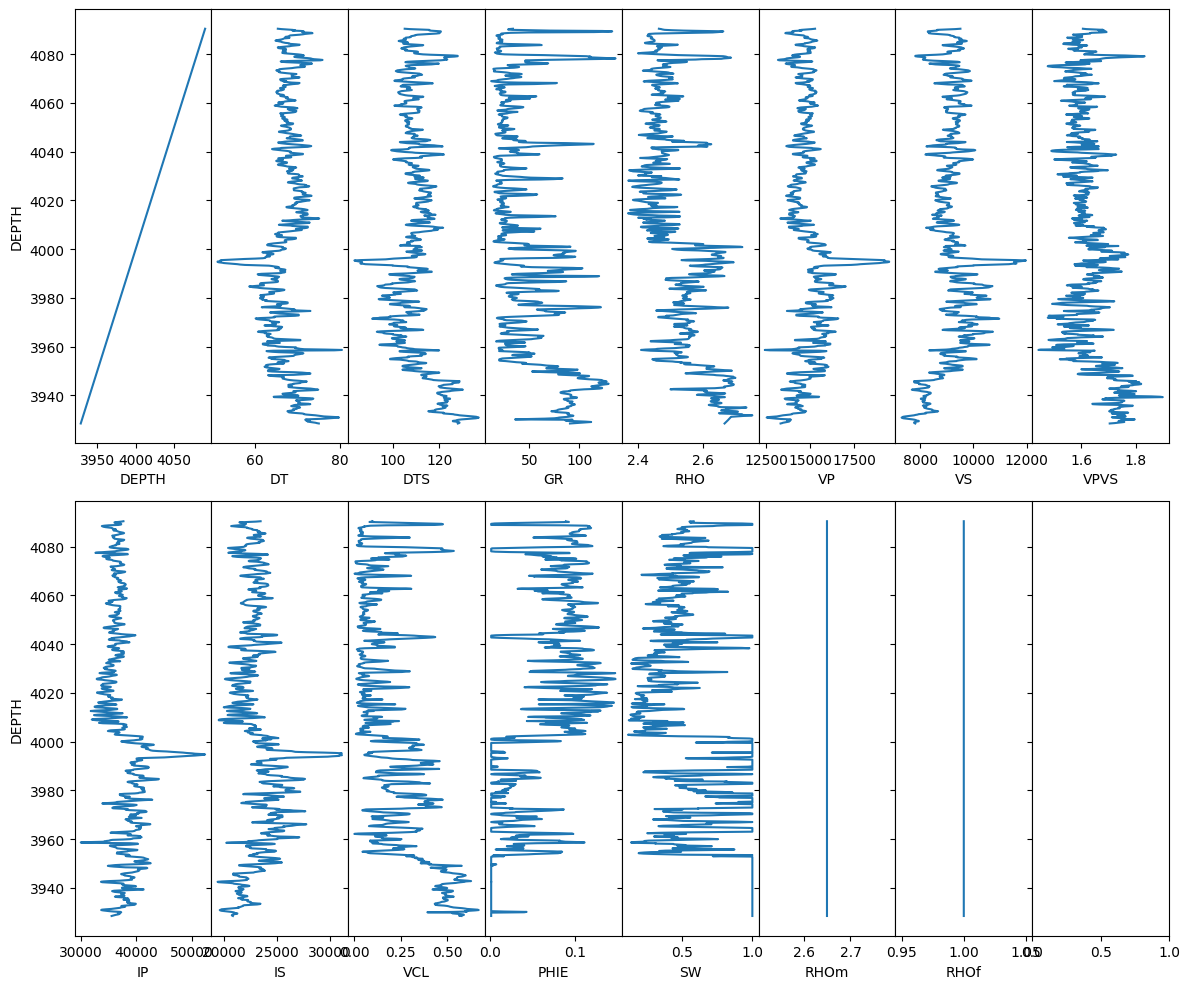

In [189]:
fig, axes = plt.subplots(2, 8, figsize=(12, 10), sharey=True, gridspec_kw={'wspace': 0})
for i, column in enumerate(L.columns):
    row = i // 8
    col = i % 8
    axes[row, col].plot(L[column], L['DEPTH'])
    axes[row, col].set_xlabel(column)
    if col == 0:
        axes[row, col].set_ylabel('DEPTH')
plt.tight_layout()
plt.show()

In [190]:
# define basic styles for plotting log curves (sty0), sand (sty1) and shale (sty2)
sty0 = {'lw':1, 'color':'k', 'ls':'-'}
sty1 = {'marker':'o', 'color':'g', 'ls':'none', 'ms':6, 'mec':'none', 'alpha':0.5}
sty2 = {'marker':'o', 'color':'r', 'ls':'none', 'ms':6, 'mec':'none', 'alpha':0.5}

def plotlog(L, cutoff_sand, cutoff_shale):
    # define filters to select sand (ss) and shale (sh)
    ss =  (L.VCL<=cutoff_sand)
    sh =  (L.VCL>=cutoff_shale)

    # plot figure
    f = plt.subplots(figsize=(14, 6))
    ax0 = plt.subplot2grid((1,9), (0,0), colspan=1) # gr curve
    ax1 = plt.subplot2grid((1,9), (0,1), colspan=1) # ip curve
    ax2 = plt.subplot2grid((1,9), (0,2), colspan=1) # vp/vs curve
    ax3 = plt.subplot2grid((1,9), (0,3), colspan=3) # crossplot phi - vp
    ax4 = plt.subplot2grid((1,9), (0,6), colspan=3) # crossplot ip - vp/vs

    ax0.plot(L.VCL[ss], L.index[ss], **sty1)
    ax0.plot(L.VCL[sh], L.index[sh], **sty2)
    ax0.plot(L.VCL, L.index, **sty0)
    ax0.set_xlabel('VCL')
    ax0.locator_params(axis='x', nbins=2)

    ax1.plot(L.IP[ss], L.index[ss], **sty1)
    ax1.plot(L.IP[sh], L.index[sh], **sty2)
    ax1.plot(L.IP, L.index,  **sty0)
    ax1.set_xlabel('$I_\mathrm{P}$')
    ax1.locator_params(axis='x', nbins=2)

    ax2.plot(L.VPVS[ss], L.index[ss], **sty1)
    ax2.plot(L.VPVS[sh], L.index[sh], **sty2)
    ax2.plot(L.VPVS, L.index, **sty0)
    ax2.set_xlabel('$V_\mathrm{P}/V_\mathrm{S}$')
    ax2.locator_params(axis='x', nbins=2)

    ax3.plot(L.PHIE[ss], L.VP[ss], **sty1)
    ax3.set_xlabel('$V_\mathrm{P}$ vs $\phi_\mathrm{e}$')

    ax4.plot(L.VP*L.RHO[ss], L.VP/L.VS[ss], **sty1)
    ax4.plot(L.VP*L.RHO[sh], L.VP/L.VS[sh], **sty2)
    ax4.set_xlabel('$V_\mathrm{P}/V_\mathrm{S}$ vs $I_\mathrm{P}$')

    for ax in [ax0, ax1, ax2]:
        if ax != ax0 and ax != ax1 and ax != ax2:
            ax.remove()
    for aa in [ax0,ax1,ax2,ax3,ax4]:
        aa.tick_params(which='major', labelsize=8)
    for aa in [ax1,ax2]:
        aa.set_yticklabels([])
    plt.subplots_adjust(wspace=.8,left=0.05,right=0.95)
    plt.show()

<ipython-input-190-7f9ea6276f0f>:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0 = plt.subplot2grid((1,9), (0,0), colspan=1) # gr curve


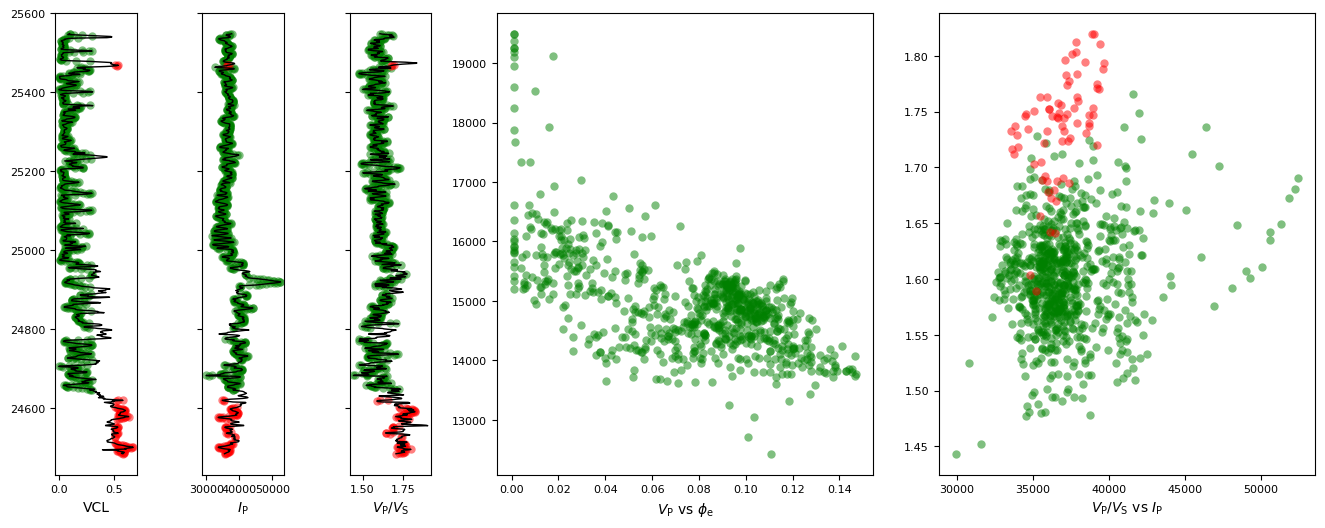

In [191]:
plotlog(L, 0.3, 0.5)

In [192]:
L.shape, L.columns

((1064, 15),
 Index(['DEPTH', 'DT', 'DTS', 'GR', 'RHO', 'VP', 'VS', 'VPVS', 'IP', 'IS',
        'VCL', 'PHIE', 'SW', 'RHOm', 'RHOf'],
       dtype='object'))

In [193]:
phi=L.PHIE.values
sw=L.SW.values
vsh=L.VCL.values
fluid='gas'

In [194]:
def vrh_new(volumes,k,mu):
    '''
    Calculates Voigt-Reuss-Hill bounds, (C) aadm 2015

    INPUT
    volumes: array with volumetric fractions
    k: array with bulk modulus
    mu: array with shear modulus

    OUTPUT
    k_u, k_l: upper (Voigt) and lower (Reuss) average of k
    mu_u, mu_l: upper (Voigt) and lower (Reuss) average of mu
    k0, mu0: Hill average of k and mu
    '''
    f=np.array(volumes).T
    k=np.resize(np.array(k),np.shape(f))
    mu=np.resize(np.array(mu),np.shape(f))
    ax=0 if f.ndim==1 else 1
    k_u = np.sum(f*k,axis=ax)
    k_l = 1./np.sum(f/k,axis=ax)
    mu_u = np.sum(f*mu,axis=ax)
    mu_l = 1./np.sum(f/mu,axis=ax)
    k0 = (k_u+k_l)/2.
    mu0 = (mu_u+mu_l)/2.
    return k_u, k_l, mu_u, mu_l, k0, mu0

In [195]:
K0,G0 = vrh_new([vsh, 1-vsh],[Ksh,Kqz],[Gsh,Gqz])[4:]
D0 = vsh*Dsh+(1-vsh)*Dqz

In [196]:
Kdry,Gdry= SoftSandModel(K0, G0, phi, phic=0.4, Cn=8.6, sigma=10, f=1)

In [197]:
# setup empty arrays to store Ip and Vp/Vs values
xx=np.empty((phi.size,sw.size))
yy=np.empty((phi.size,sw.size))
np.shape(xx)

(1064, 1064)

In [198]:
(Khc, Dhc) = (Kg, Dg) if fluid == 'gas' else (Ko,Do)
def vels(K_DRY,G_DRY,K0,D0,Kf,Df,phi):
    '''
    Calculates velocities and densities of saturated rock via Gassmann equation, (C) aadm 2015

    INPUT
    K_DRY,G_DRY: dry rock bulk & shear modulus in GPa
    K0, D0: mineral bulk modulus and density in GPa
    Kf, Df: fluid bulk modulus and density in GPa
    phi: porosity
    '''
    rho  = D0*(1-phi)+Df*phi
    K = K_DRY + (1-K_DRY/K0)**2 / ( (phi/Kf) + ((1-phi)/K0) - (K_DRY/K0**2) )
    vp   = np.sqrt((K+4./3*G_DRY)/rho)*1e3
    vs   = np.sqrt(G_DRY/rho)*1e3
    return vp, vs, rho, K

In [199]:
for i,val in enumerate(sw):
    Kf = vrh_new([val,1-val],[Kb,Khc],[9999,9999])[1]
    Df = val*Db+(1-val)*Dhc
    vp,vs,rho,_= vels(Kdry,Gdry,K0,D0,Kf,Df,phi)
    xx[:,i]=vp*rho
    yy[:,i]=vp/vs

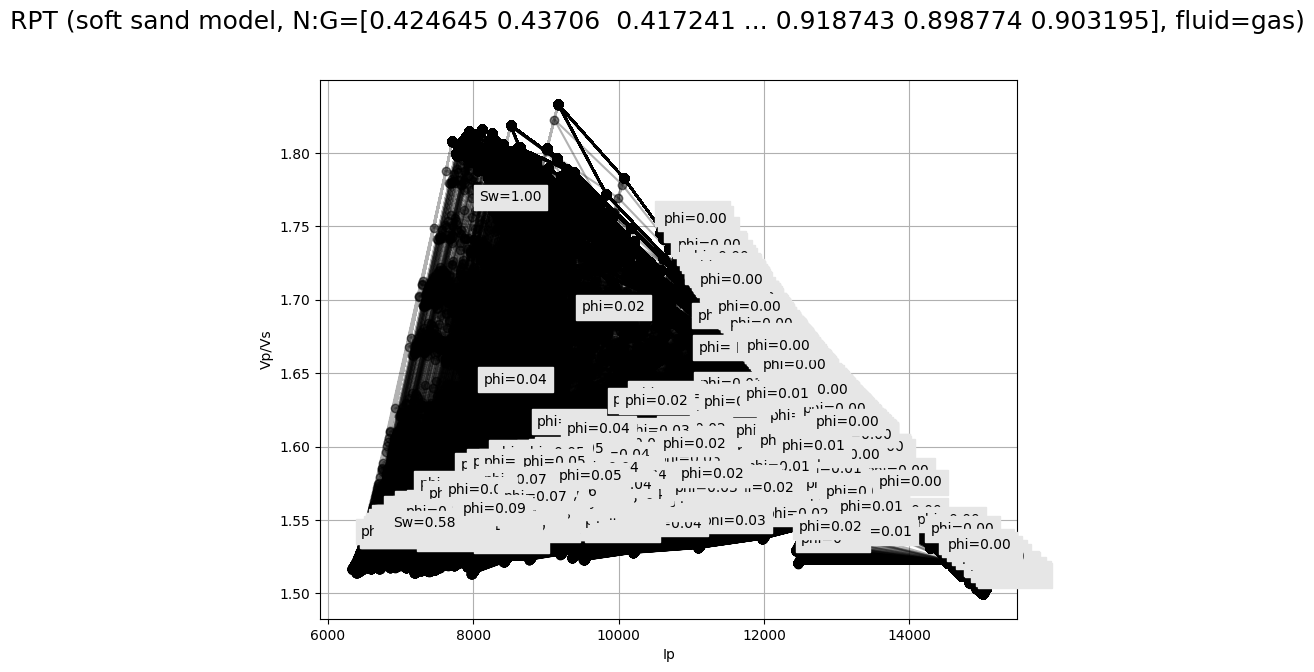

In [200]:
plt.figure(figsize=(9,7))
plt.plot(xx, yy, '-ok', alpha=0.3)
plt.plot(xx.T, yy.T, '-ok', alpha=0.3)
for i,val in enumerate(phi):
    plt.text(xx[i,-1],yy[i,-1]+.01,'phi={:.02f}'.format(val), backgroundcolor='0.9')
plt.text(xx[-1,0]-100,yy[-1,0],'Sw={:.02f}'.format(sw[0]),ha='right', backgroundcolor='0.9')
plt.text(xx[-1,-1]-100,yy[-1,-1],'Sw={:.02f}'.format(sw[-1]),ha='right', backgroundcolor='0.9')
plt.xlabel('Ip'), plt.ylabel('Vp/Vs')
plt.suptitle('RPT (soft sand model, N:G={0}, fluid={1})'.format(1-vsh, fluid),fontsize=18)
plt.grid()
plt.show()

In [201]:
def rpt(model='soft',vsh=0.0,fluid='gas',phic=0.4,Cn=8,P=10,f=1,cement='quartz'):
    if cement=='quartz':
        Kc, Gc = 37, 45
    elif cement=='calcite':
        Kc, Gc = 76.8, 32
    elif cement=='clay':
        Kc, Gc = 21, 7
    phi=np.linspace(0.1,phic-.1,8)
    sw=np.linspace(0,1,5)
    if fluid == 'gas':
        (Khc, Dhc) = (Kg, Dg)
    elif  fluid == 'brine':
        (Khc, Dhc) = (Kb, Db)
    elif fluid == 'oil':
        (Khc, Dhc) = (Ko, Do)
    K0,G0 = vrh_new([vsh, 1-vsh],[Ksh,Kqz],[Gsh,Gqz])[4:]
    D0 = vsh*Dsh+(1-vsh)*Dqz
    if model=='SoftSandModel':
        Kdry, Gdry = SoftSandModel(K0,G0,phi,phic,Cn,P,f)
    elif model=='StiffSandModel':
         Kdry, Gdry = StiffSandModel(K0,G0,phi,phic,Cn,P,f)
    elif model=='contactcement':
         Kdry, Gdry = contactcement(K0,G0,phi,phic,Cn,Kc,Gc,scheme=2)
    elif model=='crit':
         Kdry, Gdry = Cpor_model(K0,G0,phi,phic)

    xx=np.empty((phi.size,sw.size))
    yy=np.empty((phi.size,sw.size))

    for i,val in enumerate(sw):
        Kf = vrh_new([val,1-val],[Kb,Khc],[999,999])[1]
        Df = val*Db+(1-val)*Dhc
        vp,vs,rho,_= vels(Kdry,Gdry,K0,D0,Kf,Df,phi)
        xx[:,i]=vp*rho
        yy[:,i]=vp/vs

    opt1={'backgroundcolor':'0.9'}
    opt2={'ha':'right','backgroundcolor':'0.9'}
    #plt.scatter(AI,Vp/vs)     ## we need to include the well data here
    plt.figure(figsize=(9,7))
    plt.plot(xx, yy, '-ok', alpha=0.3)
    plt.plot(xx.T, yy.T, '-ok', alpha=0.3)
    for i,val in enumerate(phi):
        plt.text(xx[i,-1],yy[i,-1]+.01,'$\phi={:.02f}$'.format(val), **opt1)
    plt.text(xx[-1,0]-100,yy[-1,0],'$S_w={:.02f}$'.format(sw[0]), **opt2)
    plt.text(xx[-1,-1]-100,yy[-1,-1],'$S_w={:.02f}$'.format(sw[-1]), **opt2)
    plt.xlabel('Ip'), plt.ylabel('Vp/Vs')
    plt.xlim(xx.min()-xx.min()*.1,xx.max()+xx.max()*.1)
    plt.ylim(yy.min()-yy.min()*.1,yy.max()+yy.max()*.1)
    plt.suptitle('Model={0}, Vsh={1}, fluid={2}'.format(model,vsh, fluid),fontsize=17)
    plt.grid()

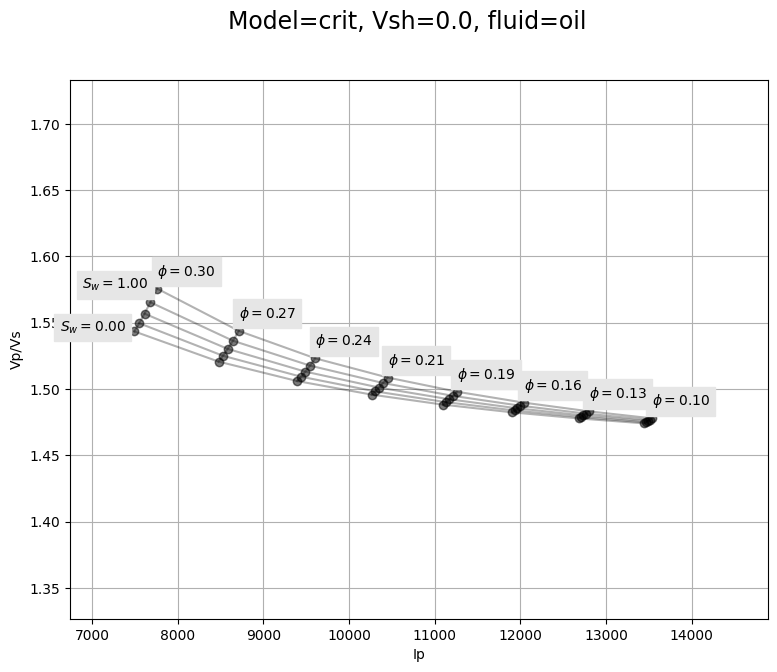

In [202]:
rpt(model='crit',vsh=0.0,fluid='oil',phic=0.4,Cn=8,P=10,f=1,cement='quartz')
#plt.savefig('C:/Users/User/OneDrive/Desktop/Dissertation/My code/figures/RPT_cp_oil',dpi=450,bbox_inches='tight')

interactive(children=(ToggleButtons(description='RPM', options=('SoftSandModel', 'StiffSandModel', 'contactcem…

<function __main__.rpt(model='soft', vsh=0.0, fluid='gas', phic=0.4, Cn=8, P=10, f=1, cement='quartz')>

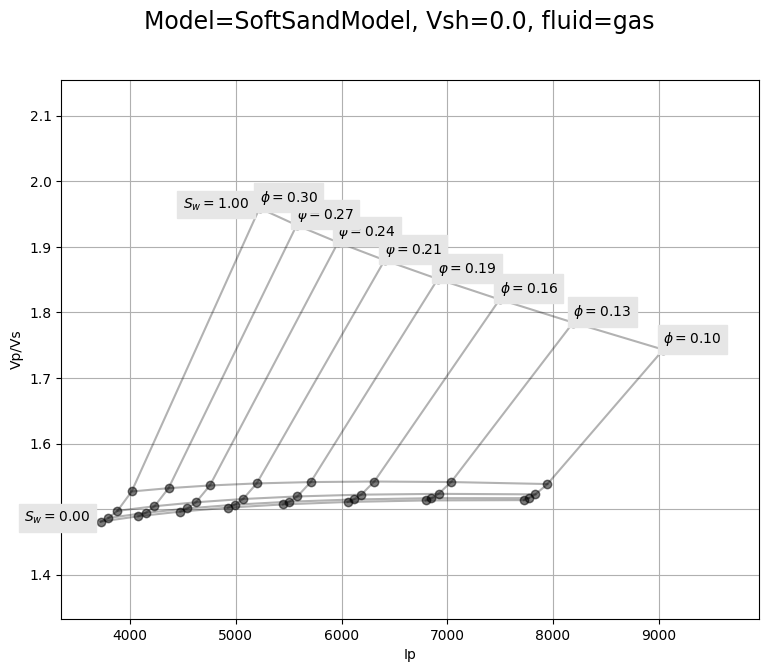

In [203]:
from ipywidgets import interact, ToggleButtons, RadioButtons, HTML
rpm_buttons = ToggleButtons(description='RPM',options=['SoftSandModel','StiffSandModel','contactcement','crit'])
fluid_buttons = ToggleButtons(description='Fluid',options=['gas','oil','brine'])
cement_buttons = ToggleButtons(description='Cement',options=['quartz','clay','calcite'])
interact(rpt,
         model=rpm_buttons, fluid=fluid_buttons,
         vsh=(0,1,.1),phic=(.2,0.4,.01),Cn=(1,20),P=(1,100),f=(0,1,.1),
         cement=cement_buttons)


In [204]:
L.columns

Index(['DEPTH', 'DT', 'DTS', 'GR', 'RHO', 'VP', 'VS', 'VPVS', 'IP', 'IS',
       'VCL', 'PHIE', 'SW', 'RHOm', 'RHOf'],
      dtype='object')

In [205]:
Vp= ((10**6/L['DT']))/3.28

In [206]:
Vs=  ((10**6/L['DTS']))/3.28

In [207]:
V_ratio = Vp/Vs

In [208]:
AI = L['RHO']*Vp

In [209]:
L_new = L.copy()
L_new["VPVS"]=V_ratio
L_new['IP'] = AI
L_new['Vp'] = Vp
L_new['Vs'] = Vs
L_new.head()

,DEPTH,DT,DTS,GR,RHO,VP,VS,VPVS,IP,IS,VCL,PHIE,SW,RHOm,RHOf,Vp,Vs
24485,3928.41373,75.0295,127.905,90.7562,2.6661,13328.0908,7818.3027,1.704729,10833.543684,20844.3184,0.575355,0.001001,1.0,2.65,1,4063.442363,2383.628856
24486,3928.56613,74.5634,128.394,95.7989,2.6673,13411.4053,7788.5259,1.721944,10906.171386,20774.0898,0.562940,0.001001,1.0,2.65,1,4088.843169,2374.550593
24487,3928.71853,74.2541,128.675,100.0100,2.6684,13467.2705,7771.5171,1.732901,10956.116704,20737.8613,0.582759,0.001001,1.0,2.65,1,4105.874945,2369.365058
24488,3928.87093,73.6112,128.530,106.8610,2.6696,13584.8896,7780.2847,1.746066,11056.774499,20770.4062,0.589147,0.001001,1.0,2.65,1,4141.734529,2372.038036
24489,3929.02333,72.8832,128.140,112.0420,2.6708,13720.5830,7803.9644,1.758156,11172.235751,20842.8008,0.586680,0.001001,1.0,2.65,1,4183.104594,2379.257443


In [210]:
def rpt(model='soft',vsh=0.0,fluid='gas',phic=0.4,Cn=8,P=10,f=1,cement='quartz'):
    if cement=='quartz':
        Kc, Gc = 37, 45
    elif cement=='calcite':
        Kc, Gc = 76.8, 32
    elif cement=='clay':
        Kc, Gc = 21, 7
    phi=np.linspace(0.1,phic-.1,8)
    sw=np.linspace(0,1,5)
    if fluid == 'gas':
        (Khc, Dhc) = (Kg, Dg)
    elif  fluid == 'brine':
        (Khc, Dhc) = (Kb, Db)
    elif fluid == 'oil':
        (Khc, Dhc) = (Ko, Do)
    K0,G0 = vrh_new([vsh, 1-vsh],[Ksh,Kqz],[Gsh,Gqz])[4:]
    D0 = vsh*Dsh+(1-vsh)*Dqz
    if model=='SoftSandModel':
        Kdry, Gdry = SoftSandModel(K0,G0,phi,phic,Cn,P,f)
    elif model=='StiffSandModel':
         Kdry, Gdry = StiffSandModel(K0,G0,phi,phic,Cn,P,f)
    elif model=='contactcement':
         Kdry, Gdry = contactcement(K0,G0,phi,phic,Cn,Kc,Gc,scheme=2)
    elif model=='crit':
         Kdry, Gdry = Cpor_model(K0,G0,phi,phic)

    xx=np.empty((phi.size,sw.size))
    yy=np.empty((phi.size,sw.size))

    for i,val in enumerate(sw):
        Kf = vrh_new([val,1-val],[Kb,Khc],[999,999])[1]
        Df = val*Db+(1-val)*Dhc
        vp,vs,rho,_= vels(Kdry,Gdry,K0,D0,Kf,Df,phi)
        xx[:,i]=vp*rho
        yy[:,i]=vp/vs

    opt1={'backgroundcolor':'0.9'}
    opt2={'ha':'right','backgroundcolor':'0.9'}
    plt.figure(figsize=(9,7))
    plt.scatter(AI,V_ratio,c=L_new["PHIE"])
    plt.colorbar(label='Porosity')
    plt.plot(xx, yy, '-ok', alpha=0.3)
    plt.plot(xx.T, yy.T, '-ok', alpha=0.3)
    for i,val in enumerate(phi):
        plt.text(xx[i,-1],yy[i,-1]+.01,'$\phi={:.02f}$'.format(val), **opt1)
    plt.text(xx[-1,0]-100,yy[-1,0],'$S_w={:.02f}$'.format(sw[0]), **opt2)
    plt.text(xx[-1,-1]-100,yy[-1,-1],'$S_w={:.02f}$'.format(sw[-1]), **opt2)
    plt.xlabel('Ip'), plt.ylabel('Vp/Vs')
    plt.xlim(xx.min()-xx.min()*.1,xx.max()+xx.max()*.1)
    plt.ylim(yy.min()-yy.min()*.1,yy.max()+yy.max()*.1)
    plt.suptitle('Model={0}, Vsh={1}, fluid={2}'.format(model,vsh, fluid),fontsize=17)
    plt.grid()

interactive(children=(ToggleButtons(description='RPM', options=('SoftSandModel', 'StiffSandModel', 'contactcem…

<function __main__.rpt(model='soft', vsh=0.0, fluid='gas', phic=0.4, Cn=8, P=10, f=1, cement='quartz')>

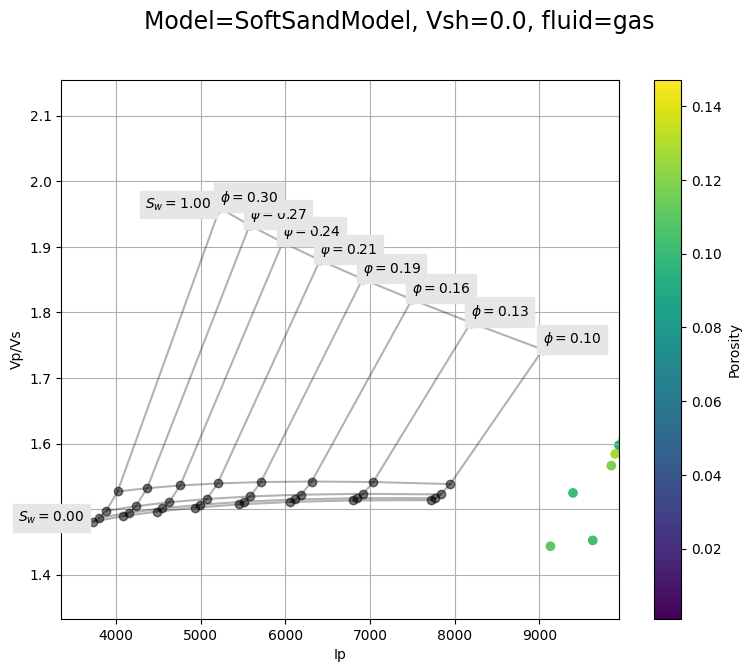

In [211]:
from ipywidgets import interact, ToggleButtons, RadioButtons, HTML
rpm_buttons = ToggleButtons(description='RPM',options=['SoftSandModel','StiffSandModel','contactcement','crit'])
fluid_buttons = ToggleButtons(description='Fluid',options=['gas','oil','brine'])
cement_buttons = ToggleButtons(description='Cement',options=['quartz','clay','calcite'])
interact(rpt,
         model=rpm_buttons, fluid=fluid_buttons,
         vsh=(0,1,.05),phic=(.2,0.4,.01),Cn=(1,20,0.2),P=(1,100),f=(0,1,.1),
         cement=cement_buttons)

figure=plt.figure(figsize=(5,9))
plt.scatter(x='Vs', y='DEPT:1', data=df,s=10, c='SWE', cmap='rainbow')
plt.colorbar(label='Water Saturation')
plt.gca().invert_yaxis()
plt.xlabel('shear Wave Velocity in m/s')
plt.ylabel('Depth in meter')
plt.suptitle('Predicted S-Wave velocity in Reservoir zone for Well 32-2-1',fontsize=12)
plt.grid()

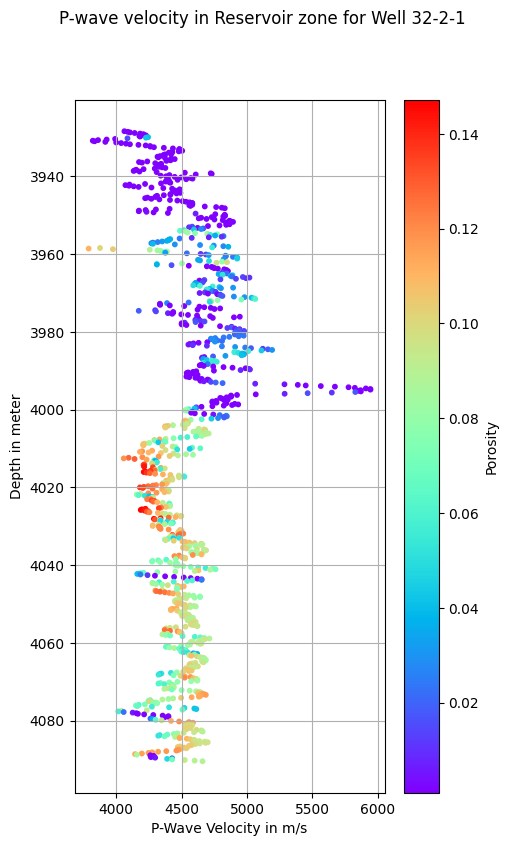

In [212]:
figure=plt.figure(figsize=(5,9))
plt.scatter(x='Vp', y='DEPTH', data=L_new,s=10, c='PHIE', cmap='rainbow')
plt.colorbar(label='Porosity')
plt.gca().invert_yaxis()
plt.xlabel('P-Wave Velocity in m/s')
plt.ylabel('Depth in meter')
plt.suptitle('P-wave velocity in Reservoir zone for Well 32-2-1',fontsize=12)
plt.grid()

In [213]:
L_new

,DEPTH,DT,DTS,GR,RHO,VP,VS,VPVS,IP,IS,VCL,PHIE,SW,RHOm,RHOf,Vp,Vs
24485,3928.41373,75.0295,127.905,90.7562,2.6661,13328.0908,7818.3027,1.704729,10833.543684,20844.3184,0.575355,0.001001,1.0000,2.65,1,4063.442363,2383.628856
24486,3928.56613,74.5634,128.394,95.7989,2.6673,13411.4053,7788.5259,1.721944,10906.171386,20774.0898,0.562940,0.001001,1.0000,2.65,1,4088.843169,2374.550593
24487,3928.71853,74.2541,128.675,100.0100,2.6684,13467.2705,7771.5171,1.732901,10956.116704,20737.8613,0.582759,0.001001,1.0000,2.65,1,4105.874945,2369.365058
24488,3928.87093,73.6112,128.530,106.8610,2.6696,13584.8896,7780.2847,1.746066,11056.774499,20770.4062,0.589147,0.001001,1.0000,2.65,1,4141.734529,2372.038036
24489,3929.02333,72.8832,128.140,112.0420,2.6708,13720.5830,7803.9644,1.758156,11172.235751,20842.8008,0.586680,0.001001,1.0000,2.65,1,4183.104594,2379.257443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25544,4089.80528,69.4505,115.553,52.8044,2.5050,14398.7441,8654.0371,1.663818,10996.602072,21678.2773,0.212732,0.048287,0.5595,2.65,1,4389.861107,2638.426080
25545,4089.95768,68.8491,115.674,32.6755,2.4821,14524.5186,8644.9844,1.680109,10991.251954,21457.5430,0.140551,0.069965,0.5678,2.65,1,4428.206742,2635.666172
25546,4090.11008,67.3853,111.016,28.5230,2.4756,14840.0322,9007.7109,1.647481,11200.604547,22299.8496,0.081257,0.092405,0.5672,2.65,1,4524.399962,2746.253232
25547,4090.26248,66.2805,107.340,29.3074,2.4717,15087.3936,9316.1914,1.619481,11369.363134,23027.0176,0.101226,0.089721,0.5532,2.65,1,4599.815161,2840.302299


# Given Formation : 3928.3m - 4090.5m

interactive(children=(ToggleButtons(description='RPM', options=('SoftSandModel', 'StiffSandModel', 'contactcem…

<function __main__.rpt(model='soft', vsh=0.0, fluid='gas', phic=0.4, Cn=8, P=10, f=1, cement='quartz')>

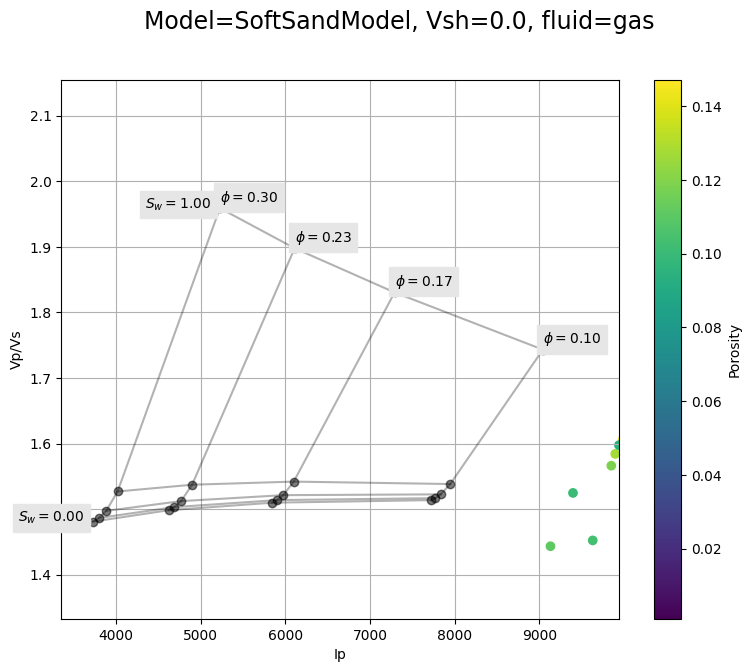

In [214]:
def rpt(model='soft',vsh=0.0,fluid='gas',phic=0.4,Cn=8,P=10,f=1,cement='quartz'):
    if cement=='quartz':
        Kc, Gc = 37, 45
    elif cement=='calcite':
        Kc, Gc = 76.8, 32
    elif cement=='clay':
        Kc, Gc = 21, 7
    phi=np.linspace(0.1,phic-.1,4)
    sw=np.linspace(0,1,5)
    if fluid == 'gas':
        (Khc, Dhc) = (Kg, Dg)
    elif  fluid == 'brine':
        (Khc, Dhc) = (Kb, Db)
    elif fluid == 'oil':
        (Khc, Dhc) = (Ko, Do)
    K0,G0 = vrh_new([vsh, 1-vsh],[Ksh,Kqz],[Gsh,Gqz])[4:]
    D0 = vsh*Dsh+(1-vsh)*Dqz
    if model=='SoftSandModel':
        Kdry, Gdry = SoftSandModel(K0,G0,phi,phic,Cn,P,f)
    elif model=='StiffSandModel':
         Kdry, Gdry = StiffSandModel(K0,G0,phi,phic,Cn,P,f)
    elif model=='contactcement':
         Kdry, Gdry = contactcement(K0,G0,phi,phic,Cn,Kc,Gc,scheme=2)
    elif model=='crit':
         Kdry, Gdry = Cpor_model(K0,G0,phi,phic)

    xx=np.empty((phi.size,sw.size))
    yy=np.empty((phi.size,sw.size))

    for i,val in enumerate(sw):
        Kf = vrh_new([val,1-val],[Kb,Khc],[999,999])[1]
        Df = val*Db+(1-val)*Dhc
        vp,vs,rho,_= vels(Kdry,Gdry,K0,D0,Kf,Df,phi)
        xx[:,i]=vp*rho
        yy[:,i]=vp/vs

    opt1={'backgroundcolor':'0.9'}
    opt2={'ha':'right','backgroundcolor':'0.9'}
    plt.figure(figsize=(9,7))
    plt.scatter(L_new['IP'],L_new['VPVS'],c=L_new["PHIE"])
    plt.colorbar(label='Porosity')
    plt.plot(xx, yy, '-ok', alpha=0.3)
    plt.plot(xx.T, yy.T, '-ok', alpha=0.3)
    for i,val in enumerate(phi):
        plt.text(xx[i,-1],yy[i,-1]+.01,'$\phi={:.02f}$'.format(val), **opt1)
    plt.text(xx[-1,0]-100,yy[-1,0],'$S_w={:.02f}$'.format(sw[0]), **opt2)
    plt.text(xx[-1,-1]-100,yy[-1,-1],'$S_w={:.02f}$'.format(sw[-1]), **opt2)
    plt.xlabel('Ip'), plt.ylabel('Vp/Vs')
    plt.xlim(xx.min()-xx.min()*.1,xx.max()+xx.max()*.1)
    plt.ylim(yy.min()-yy.min()*.1,yy.max()+yy.max()*.1)
    plt.suptitle('Model={0}, Vsh={1}, fluid={2}'.format(model,vsh, fluid),fontsize=17)
    plt.grid()
from ipywidgets import interact, ToggleButtons, RadioButtons, HTML
rpm_buttons = ToggleButtons(description='RPM',options=['SoftSandModel','StiffSandModel','contactcement','crit'])
fluid_buttons = ToggleButtons(description='Fluid',options=['gas','oil','brine'])
cement_buttons = ToggleButtons(description='Cement',options=['quartz','clay','calcite'])
interact(rpt,
         model=rpm_buttons, fluid=fluid_buttons,
         vsh=(0,1,.05),phic=(.2,0.4,.01),Cn=(1,20,0.2),P=(1,100),f=(0,1,.1),
         cement=cement_buttons)

interactive(children=(ToggleButtons(description='RPM', options=('SoftSandModel', 'StiffSandModel', 'contactcem…

<function __main__.rpt(model='soft', vsh=0.0, fluid='gas', phic=0.4, Cn=8, P=10, f=1, cement='quartz')>

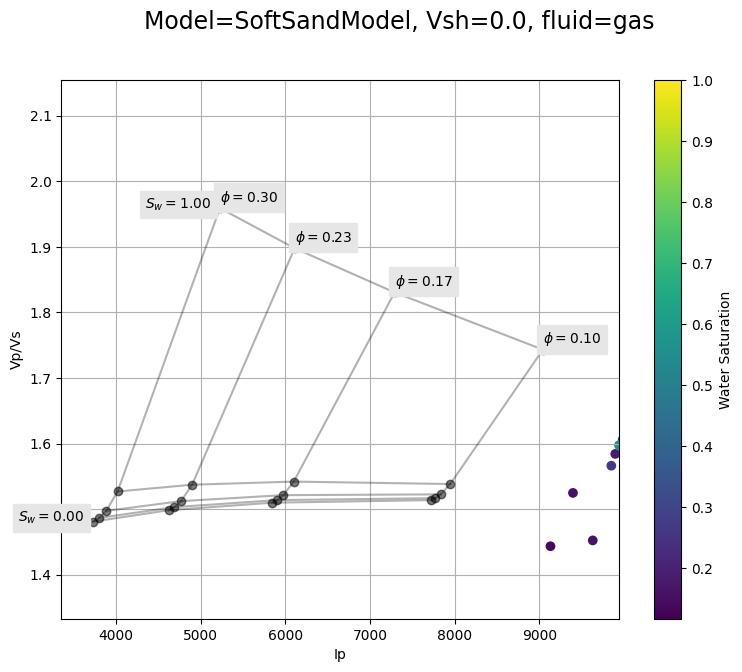

In [215]:
def rpt(model='soft',vsh=0.0,fluid='gas',phic=0.4,Cn=8,P=10,f=1,cement='quartz'):
    if cement=='quartz':
        Kc, Gc = 37, 45
    elif cement=='calcite':
        Kc, Gc = 76.8, 32
    elif cement=='clay':
        Kc, Gc = 21, 7
    phi=np.linspace(0.1,phic-.1,4)
    sw=np.linspace(0,1,5)
    if fluid == 'gas':
        (Khc, Dhc) = (Kg, Dg)
    elif  fluid == 'brine':
        (Khc, Dhc) = (Kb, Db)
    elif fluid == 'oil':
        (Khc, Dhc) = (Ko, Do)
    K0,G0 = vrh_new([vsh, 1-vsh],[Ksh,Kqz],[Gsh,Gqz])[4:]
    D0 = vsh*Dsh+(1-vsh)*Dqz
    if model=='SoftSandModel':
        Kdry, Gdry = SoftSandModel(K0,G0,phi,phic,Cn,P,f)
    elif model=='StiffSandModel':
         Kdry, Gdry = StiffSandModel(K0,G0,phi,phic,Cn,P,f)
    elif model=='contactcement':
         Kdry, Gdry = contactcement(K0,G0,phi,phic,Cn,Kc,Gc,scheme=2)
    elif model=='crit':
         Kdry, Gdry = Cpor_model(K0,G0,phi,phic)

    xx=np.empty((phi.size,sw.size))
    yy=np.empty((phi.size,sw.size))

    for i,val in enumerate(sw):
        Kf = vrh_new([val,1-val],[Kb,Khc],[999,999])[1]
        Df = val*Db+(1-val)*Dhc
        vp,vs,rho,_= vels(Kdry,Gdry,K0,D0,Kf,Df,phi)
        xx[:,i]=vp*rho
        yy[:,i]=vp/vs

    opt1={'backgroundcolor':'0.9'}
    opt2={'ha':'right','backgroundcolor':'0.9'}
    plt.figure(figsize=(9,7))
    plt.scatter(L_new['IP'],L_new['VPVS'],c=L_new["SW"])
    plt.colorbar(label='Water Saturation')
    plt.plot(xx, yy, '-ok', alpha=0.3)
    plt.plot(xx.T, yy.T, '-ok', alpha=0.3)
    for i,val in enumerate(phi):
        plt.text(xx[i,-1],yy[i,-1]+.01,'$\phi={:.02f}$'.format(val), **opt1)
    plt.text(xx[-1,0]-100,yy[-1,0],'$S_w={:.02f}$'.format(sw[0]), **opt2)
    plt.text(xx[-1,-1]-100,yy[-1,-1],'$S_w={:.02f}$'.format(sw[-1]), **opt2)
    plt.xlabel('Ip'), plt.ylabel('Vp/Vs')
    plt.xlim(xx.min()-xx.min()*.1,xx.max()+xx.max()*.1)
    plt.ylim(yy.min()-yy.min()*.1,yy.max()+yy.max()*.1)
    plt.suptitle('Model={0}, Vsh={1}, fluid={2}'.format(model,vsh, fluid),fontsize=17)
    plt.grid()
from ipywidgets import interact, ToggleButtons, RadioButtons, HTML
rpm_buttons = ToggleButtons(description='RPM',options=['SoftSandModel','StiffSandModel','contactcement','crit'])
fluid_buttons = ToggleButtons(description='Fluid',options=['gas','oil','brine'])
cement_buttons = ToggleButtons(description='Cement',options=['quartz','clay','calcite'])
interact(rpt,
         model=rpm_buttons, fluid=fluid_buttons,
         vsh=(0,1,.1),phic=(.2,0.4,.01),Cn=(1,20),P=(1,100),f=(0,1,.1),
         cement=cement_buttons)

interactive(children=(ToggleButtons(description='RPM', options=('SoftSandModel', 'StiffSandModel', 'contactcem…

<function __main__.rpt(model='soft', vsh=0.0, fluid='gas', phic=0.4, Cn=8, P=10, f=1, cement='quartz')>

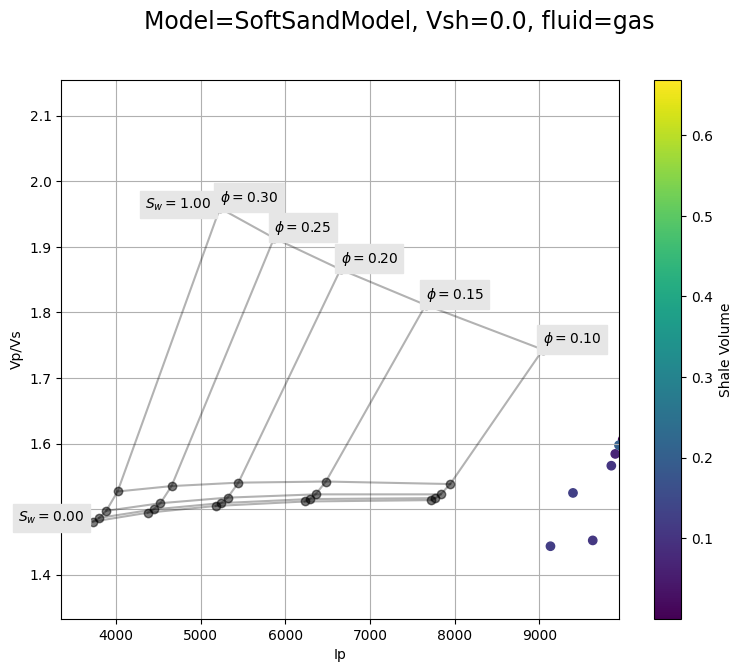

In [216]:
def rpt(model='soft',vsh=0.0,fluid='gas',phic=0.4,Cn=8,P=10,f=1,cement='quartz'):
    if cement=='quartz':
        Kc, Gc = 37, 45
    elif cement=='calcite':
        Kc, Gc = 76.8, 32
    elif cement=='clay':
        Kc, Gc = 21, 7
    phi=np.linspace(0.1,phic-.1,5)
    sw=np.linspace(0,1,5)
    if fluid == 'gas':
        (Khc, Dhc) = (Kg, Dg)
    elif  fluid == 'brine':
        (Khc, Dhc) = (Kb, Db)
    elif fluid == 'oil':
        (Khc, Dhc) = (Ko, Do)
    K0,G0 = vrh_new([vsh, 1-vsh],[Ksh,Kqz],[Gsh,Gqz])[4:]
    D0 = vsh*Dsh+(1-vsh)*Dqz
    if model=='SoftSandModel':
        Kdry, Gdry = SoftSandModel(K0,G0,phi,phic,Cn,P,f)
    elif model=='StiffSandModel':
         Kdry, Gdry = StiffSandModel(K0,G0,phi,phic,Cn,P,f)
    elif model=='contactcement':
         Kdry, Gdry = contactcement(K0,G0,phi,phic,Cn,Kc,Gc,scheme=2)
    elif model=='crit':
         Kdry, Gdry = Cpor_model(K0,G0,phi,phic)

    xx=np.empty((phi.size,sw.size))
    yy=np.empty((phi.size,sw.size))

    for i,val in enumerate(sw):
        Kf = vrh_new([val,1-val],[Kb,Khc],[999,999])[1]
        Df = val*Db+(1-val)*Dhc
        vp,vs,rho,_= vels(Kdry,Gdry,K0,D0,Kf,Df,phi)
        xx[:,i]=vp*rho
        yy[:,i]=vp/vs

    opt1={'backgroundcolor':'0.9'}
    opt2={'ha':'right','backgroundcolor':'0.9'}
    plt.figure(figsize=(9,7))
    plt.scatter(L_new['IP'],L_new['VPVS'],c=L_new["VCL"])
    plt.colorbar(label='Shale Volume')
    plt.plot(xx, yy, '-ok', alpha=0.3)
    plt.plot(xx.T, yy.T, '-ok', alpha=0.3)
    for i,val in enumerate(phi):
        plt.text(xx[i,-1],yy[i,-1]+.01,'$\phi={:.02f}$'.format(val), **opt1)
    plt.text(xx[-1,0]-100,yy[-1,0],'$S_w={:.02f}$'.format(sw[0]), **opt2)
    plt.text(xx[-1,-1]-100,yy[-1,-1],'$S_w={:.02f}$'.format(sw[-1]), **opt2)
    plt.xlabel('Ip'), plt.ylabel('Vp/Vs')
    plt.xlim(xx.min()-xx.min()*.1,xx.max()+xx.max()*.1)
    plt.ylim(yy.min()-yy.min()*.1,yy.max()+yy.max()*.1)
    plt.suptitle('Model={0}, Vsh={1}, fluid={2}'.format(model,vsh, fluid),fontsize=17)
    plt.grid()
from ipywidgets import interact, ToggleButtons, RadioButtons, HTML
rpm_buttons = ToggleButtons(description='RPM',options=['SoftSandModel','StiffSandModel','contactcement','crit'])
fluid_buttons = ToggleButtons(description='Fluid',options=['gas','oil','brine'])
cement_buttons = ToggleButtons(description='Cement',options=['quartz','clay','calcite'])
interact(rpt,
         model=rpm_buttons, fluid=fluid_buttons,
         vsh=(0,1,.1),phic=(.2,0.4,.01),Cn=(1,20),P=(1,100),f=(0,1,.1),
         cement=cement_buttons)


# Tunned model parameter

![image-2.png](attachment:image-2.png)

In [217]:
Den_qz, Kqz, Gqz = 2.65, 36.6, 45 # Quartz density and elastic properties
Den_sh, Ksh, Gsh = 2.5, 11, 3.5    # Shale density and elastic properties
Kc, Gc = 36.6, 45  #Cement's elastic co-efficients in GPa. for Quartz
                    #and for shale it will be 21,7 and 76.8 and 32 for calcite

Db, Kb = 1.0664, 2.97  # Density and Bulk Modulus of the Brine
Do, Ko = 0.8, 1.5 # Density and Bulk Modulus of the Oil
Dg, Kg = 0.2, 0.06 # Density and Bulk Modulus of the Gas

In [218]:

def final_result(df,phic,Cn,sigma,f):
    phi_m=df['PHIE'].to_numpy()
    Vsh=df['VCL'].to_numpy()
    D0 = (Vsh*Den_sh)+((1-Vsh)*Den_qz)
    _,_, K_VRH = vrh(1-Vsh,Kqz,Ksh)
    _,_,G_VRH = vrh(1-Vsh,Gqz,Gsh)
    Khm,Ghm = HM_model(K_VRH, G_VRH, phic, Cn, sigma, f)
    Kdry_hm,Gdry_hm= SoftSandModel(K_VRH, G_VRH, phi_m, phic, Cn, sigma, f)
    K,G,rho=Gassman_FS(Kdry_hm,Gdry_hm,K_VRH,Kb,D0,Db,phi_m)
    Vp,Vs=velocity(K,G,rho)
    AI = Vp*rho
    return Vp, Vs, rho, AI

In [219]:
Vp_sf1,Vs_sf1,rho_sf1,AI_sf1 = final_result(L_new, 0.37,8.4,12,1)

In [220]:
L_new['Vp_brine100']=Vp_sf1
L_new['Vs_brine100']=Vs_sf1
L_new['rho_brine100']=rho_sf1
L_new['AI_brine100']=AI_sf1

In [221]:
L_new

,DEPTH,DT,DTS,GR,RHO,VP,VS,VPVS,IP,IS,...,PHIE,SW,RHOm,RHOf,Vp,Vs,Vp_brine100,Vs_brine100,rho_brine100,AI_brine100
24485,3928.41373,75.0295,127.905,90.7562,2.6661,13328.0908,7818.3027,1.704729,10833.543684,20844.3184,...,0.001001,1.0000,2.65,1,4063.442363,2383.628856,3764.126358,2271.307779,2.562198,9644.436861
24486,3928.56613,74.5634,128.394,95.7989,2.6673,13411.4053,7788.5259,1.721944,10906.171386,20774.0898,...,0.001001,1.0000,2.65,1,4088.843169,2374.550593,3796.923205,2296.587792,2.564058,9735.532618
24487,3928.71853,74.2541,128.675,100.0100,2.6684,13467.2705,7771.5171,1.732901,10956.116704,20737.8613,...,0.001001,1.0000,2.65,1,4105.874945,2369.365058,3744.530455,2256.159149,2.561088,9590.073766
24488,3928.87093,73.6112,128.530,106.8610,2.6696,13584.8896,7780.2847,1.746066,11056.774499,20770.4062,...,0.001001,1.0000,2.65,1,4141.734529,2372.038036,3727.598759,2243.042960,2.560131,9543.141985
24489,3929.02333,72.8832,128.140,112.0420,2.6708,13720.5830,7803.9644,1.758156,11172.235751,20842.8008,...,0.001001,1.0000,2.65,1,4183.104594,2379.257443,3734.140514,2248.113561,2.560501,9561.270170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25544,4089.80528,69.4505,115.553,52.8044,2.5050,14398.7441,8654.0371,1.663818,10996.602072,21678.2773,...,0.048287,0.5595,2.65,1,4389.861107,2638.426080,3821.472964,2157.556372,2.543163,9718.630271
25545,4089.95768,68.8491,115.674,32.6755,2.4821,14524.5186,8644.9844,1.680109,10991.251954,21457.5430,...,0.069965,0.5678,2.65,1,4428.206742,2635.666172,3699.990401,2039.124576,2.519596,9322.482675
25546,4090.11008,67.3853,111.016,28.5230,2.4756,14840.0322,9007.7109,1.647481,11200.604547,22299.8496,...,0.092405,0.5672,2.65,1,4524.399962,2746.253232,3589.797456,1948.671492,2.492605,8947.948280
25547,4090.26248,66.2805,107.340,29.3074,2.4717,15087.3936,9316.1914,1.619481,11369.363134,23027.0176,...,0.089721,0.5532,2.65,1,4599.815161,2840.302299,3572.249190,1934.079927,2.494096,8909.533829


# CO2 Substitutuon

**1.Super Critical CO2**

In [222]:
def final_result_co2100(df,phic,Cn,sigma,f):
    phi_m=df['PHIE'].to_numpy()
    Vsh=df['VCL'].to_numpy()
    D0 = (Vsh*Den_sh)+((1-Vsh)*Den_qz)
    _,_, K_VRH = vrh(1-Vsh,Kqz,Ksh)
    _,_,G_VRH = vrh(1-Vsh,Gqz,Gsh)
    Khm,Ghm = HM_model(K_VRH, G_VRH, phic, Cn, sigma, f)
    Kdry_hm,Gdry_hm= SoftSandModel(K_VRH, G_VRH, phi_m, phic, Cn, sigma, f)
    kco2 = 0.1
    D0 = (Vsh*Den_sh)+((1-Vsh)*Den_qz)
    Dco2 = 0.55
    K,G,rho=Gassman_FS(Kdry_hm,Gdry_hm,K_VRH,kco2,D0,Dco2,phi_m)
    Vp,Vs=velocity(K,G,rho)
    AI = Vp*rho
    return Vp, Vs, rho, AI

In [223]:
Vpco2_sc,Vsco2_sc,rhoco2_sc,AIco2_sc = final_result_co2100(L_new, 0.37,8.4,12,1)

In [224]:
L_new['Vp_co2_100']=Vpco2_sc
L_new['Vs_co2_100']=Vsco2_sc
L_new['rho_co2_100']=rhoco2_sc
L_new['AI_co2_100']=AIco2_sc

In [225]:
def final_result_co2_50(df,phic,Cn,sigma,f):
    phi_m=df['PHIE'].to_numpy()
    Vsh=df['VCL'].to_numpy()
    D0 = (Vsh*Den_sh)+((1-Vsh)*Den_qz)
    _,_, K_VRH = vrh(1-Vsh,Kqz,Ksh)
    _,_,G_VRH = vrh(1-Vsh,Gqz,Gsh)
    _,_,kco2_VRH = vrh(0.5,0.1,Kb)
    Khm,Ghm = HM_model(K_VRH, G_VRH, phic, Cn, sigma, f)
    Kdry_hm,Gdry_hm= SoftSandModel(K_VRH, G_VRH, phi_m, phic, Cn, sigma, f)
    D0 = (Vsh*Den_sh)+((1-Vsh)*Den_qz)
    Dco2_50 = (0.5*0.5)+(1*0.5)
    K,G,rho=Gassman_FS(Kdry_hm,Gdry_hm,K_VRH,kco2_VRH,D0,Dco2_50,phi_m)
    Vp,Vs=velocity(K,G,rho)
    AI = Vp*rho
    return Vp, Vs, rho, AI

In [226]:
Vpco2_50,Vsco2_50,rhoco2_50,AIco2_50 = final_result_co2_50(L_new, 0.37,8.4,12,1)

In [227]:
L_new['Vp_co2_50']=Vpco2_50
L_new['Vs_co2_50']=Vsco2_50
L_new['rho_co2_50']=rhoco2_50
L_new['AI_co2_50']=AIco2_50

In [228]:
L_new.columns

Index(['DEPTH', 'DT', 'DTS', 'GR', 'RHO', 'VP', 'VS', 'VPVS', 'IP', 'IS',
       'VCL', 'PHIE', 'SW', 'RHOm', 'RHOf', 'Vp', 'Vs', 'Vp_brine100',
       'Vs_brine100', 'rho_brine100', 'AI_brine100', 'Vp_co2_100',
       'Vs_co2_100', 'rho_co2_100', 'AI_co2_100', 'Vp_co2_50', 'Vs_co2_50',
       'rho_co2_50', 'AI_co2_50'],
      dtype='object')

In [229]:
L_new.head()

,DEPTH,DT,DTS,GR,RHO,VP,VS,VPVS,IP,IS,...,rho_brine100,AI_brine100,Vp_co2_100,Vs_co2_100,rho_co2_100,AI_co2_100,Vp_co2_50,Vs_co2_50,rho_co2_50,AI_co2_50
24485,3928.41373,75.0295,127.905,90.7562,2.6661,13328.0908,7818.3027,1.704729,10833.543684,20844.3184,...,2.562198,9644.436861,3749.524085,2271.536929,2.561681,9605.084755,3758.147767,2271.448172,2.561881,9627.928259
24486,3928.56613,74.5634,128.394,95.7989,2.6673,13411.4053,7788.5259,1.721944,10906.171386,20774.0898,...,2.564058,9735.532618,3782.294807,2296.819324,2.563541,9696.069422,3790.900265,2296.729644,2.563742,9718.888808
24487,3928.71853,74.2541,128.675,100.0100,2.6684,13467.2705,7771.5171,1.732901,10956.116704,20737.8613,...,2.561088,9590.073766,3729.942620,2256.386869,2.560572,9550.784959,3738.578027,2256.298666,2.560772,9573.645001
24488,3928.87093,73.6112,128.530,106.8610,2.6696,13584.8896,7780.2847,1.746066,11056.774499,20770.4062,...,2.560131,9543.141985,3713.022672,2243.269441,2.559614,9503.905965,3721.668732,2243.181718,2.559815,9526.781622
24489,3929.02333,72.8832,128.140,112.0420,2.6708,13720.5830,7803.9644,1.758156,11172.235751,20842.8008,...,2.560501,9561.270170,3719.559968,2248.340521,2.559984,9522.013968,3728.201854,2248.252612,2.560184,9544.883443
